In [1]:
import readSim as rs 

import numpy as np
from numba import njit

import scipy.optimize as op

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib widget

In [2]:
sims = rs.Sims('/home/lorenzo/phd/LQG/ClosedUniverse_TimeVSa0')

In [3]:
a0s = []
times = []

for sim in sims.keylist:

    # if sims[sim].a0 > 520: continue

    a0s.append(sims[sim].a0)
    times.append(sims[sim].find_timeout())

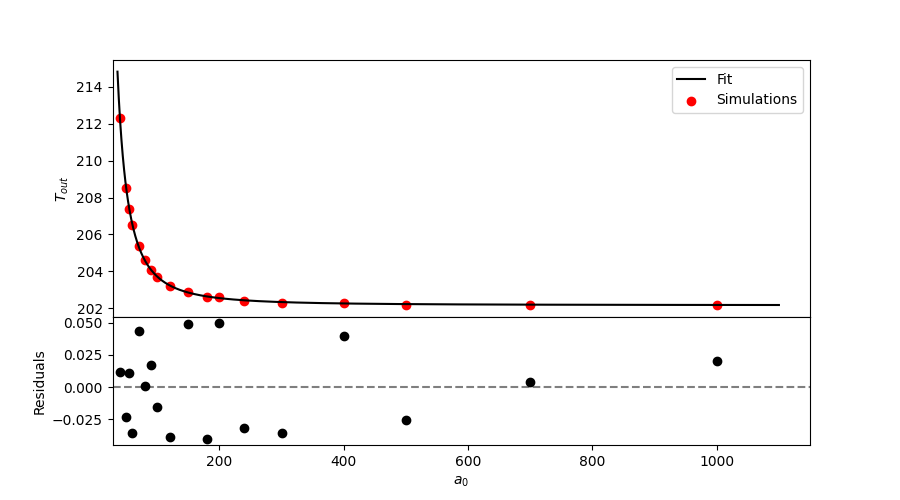

[ 3.07525587 -0.80242377]


In [4]:
def residual_plot(x, y, func, popt, pcov):

    fig = plt.figure(figsize=(9,5))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

    ax0 = plt.subplot(gs[0])

    xxx = np.linspace(0.9*np.min(x), 1.1*np.max(x), 1000)
    plt.plot(xxx, func(xxx, *popt), color = 'k', label = 'Fit')

    ax0.scatter(x, y, color = 'r', label='Simulations')

    ax0.set_ylabel(r'$T_{out}$')
    ax0.legend()

    ###############
    ### RESIDUALS
    ###############
    res = np.array(y) - func(np.array(x), *popt)

    ax1 = plt.subplot(gs[1], sharex = ax0)

    ax1.axhline(0, ls = '--', color = 'k', alpha = 0.5)
    # Residuals of fitted points
    plt.scatter(x, res, color = 'k')

    ax1.set_xlabel(r'$a_0$')
    ax1.set_ylabel('Residuals')

    ax0.set_xlim(0.7*np.min(x), 1.15*np.max(x))

    # remove vertical gap between subplots
    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.subplots_adjust(hspace=.0)
    plt.show()

    # Errors in parameters
    pi_opt = np.round(popt[0],2)
    s_pcov = np.sqrt(np.diagonal(pcov))
    text = f"Best fit parameters: " + fr"$\pi \approx {pi_opt} \pm {round_measurement(pi_opt, s_pcov[0])}$" 
    ax0.set_title(text)

    ax1.set_xscale('log')

    return res

def round_measurement(value, uncertainty):
    # Count the number of significant digits in the measurement
    num_significant_digits = len(str(value).replace('.', '').lstrip('0'))

    # Round the uncertainty to the same number of significant digits
    rounded_uncertainty = round(uncertainty, num_significant_digits - 1)
    return rounded_uncertainty

def fxb(x, alpha, rs):
    return 1 + alpha / x**2 - rs / x**3

def func(a0, pi, b):
    eps0 = - ( 10 / a0 )**2
    rs = 2 * 5

    xbs = np.zeros_like(a0)
    for i, eps in enumerate(eps0):
        xbs[i] = op.brentq(fxb, 1e-6, 5, args = (-eps, rs))

    log_term_1 = np.log1p(eps0)  # np.log1p(x) calculates log(1 + x) more accurately for small x
    log_term_2 = np.log1p(xbs * eps0 / rs)

    return pi * (2 * rs**2 * log_term_1 + rs**2 * eps0 * (eps0 - 2) - 2 * rs**2 * log_term_2 - eps0 * xbs * (eps0 * xbs - 2 * rs)) / eps0**3 + b
    

    # return pi * rs**2 * (2*log_term_1 + (eps0 - 1)**2 - 1) / eps0**3 + b

popt, pcov = op.curve_fit(func, a0s, times ) # , bounds=(0, np.inf)
residuals = residual_plot(a0s, times, func, popt, pcov)

print(popt)


In [5]:
func(np.array([28]), *popt)

array([224.39525684])

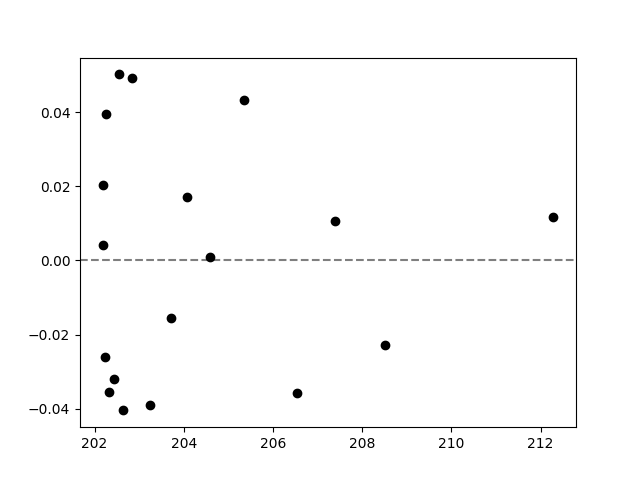

In [6]:
prediction = func(np.array(a0s), *popt)

fig = plt.figure()
plt.scatter(prediction, residuals, color = 'k')

plt.axhline(0, ls='--', color='k', alpha = 0.5)

1.619563742375855e-11


Text(0.5, 1.0, 'Mean = 0.0; $\\sigma$ = 0.031')

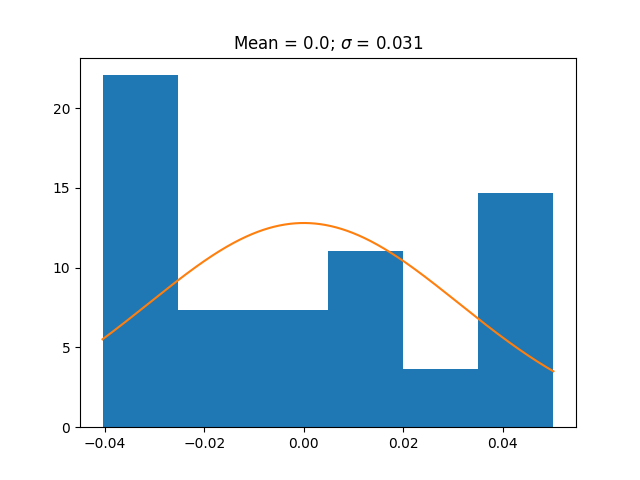

In [13]:
from scipy.stats import norm

fig = plt.figure()
_, bins, _ = plt.hist(residuals, 6, density=True)

(mu, sigma) = norm.fit(residuals)

x = np.linspace(np.min(bins), np.max(bins), 1000)
best_fit_line = norm.pdf(x, mu, sigma)
plt.plot(x, best_fit_line)

print(mu)
plt.title(fr'Mean = {np.round(mu,3)}; $\sigma$ = {np.round(sigma,3)}')